In [83]:
function ruleGen(rule::Int)
    rule = digits(rule, base=2, pad=8)
    rules = Dict{Array{Bool,1}, Bool}()
    
    for i in 0:7
        x = digits(i, base=2, pad=3)
        #println(rule[i+1], " -> ", x)
        rules[[x[3], x[2], x[1]]] = rule[i+1]
    end
    
    return rules
end

function CA(rule::Int, seed::Array{Bool,1}, iterations::Int)
    if !(rule >= 0 && rule <= 255)
        error("Incorrect rule [0-255]")
    end
    
    if (iterations < 1)
        error("Must have positive iterations.")
    end
    
    rules = ruleGen(rule)
    
    n = length(seed)
    result = falses(n,iterations+1)
    state = falses(3)
    
    result[:,1] = seed
    
    for it in 2:iterations+1
        for i in 1:n
            left = mod1(i-1, n)
            right = mod1(i+1, n)
            
            state[1] = result[left, it-1]
            state[2] = result[i, it-1]
            state[3] = result[right, it-1]
            
            result[i, it] = rules[state]
        end
    end
    
    return result
end

function CA(rule::Int, seed::BitArray{1}, iterations::Int)
    seed = convert(Array{Bool,1}, seed)
    
    return CA(rule, seed, iterations)
end

function CA(rule::Int, seed::Array{<:Int, 1}, iterations::Int)
    int_to_bool = x->convert(Array{Bool,1},x)
    return CA(rule, int_to_bool(seed), iterations)
end

CA (generic function with 3 methods)

Generate the strings to control the matrix so we can quickly verify CA functionality.

 - A - GND
 - B - 1.3 V
 - C - 3.3 V
 - D - Current source (V sense)

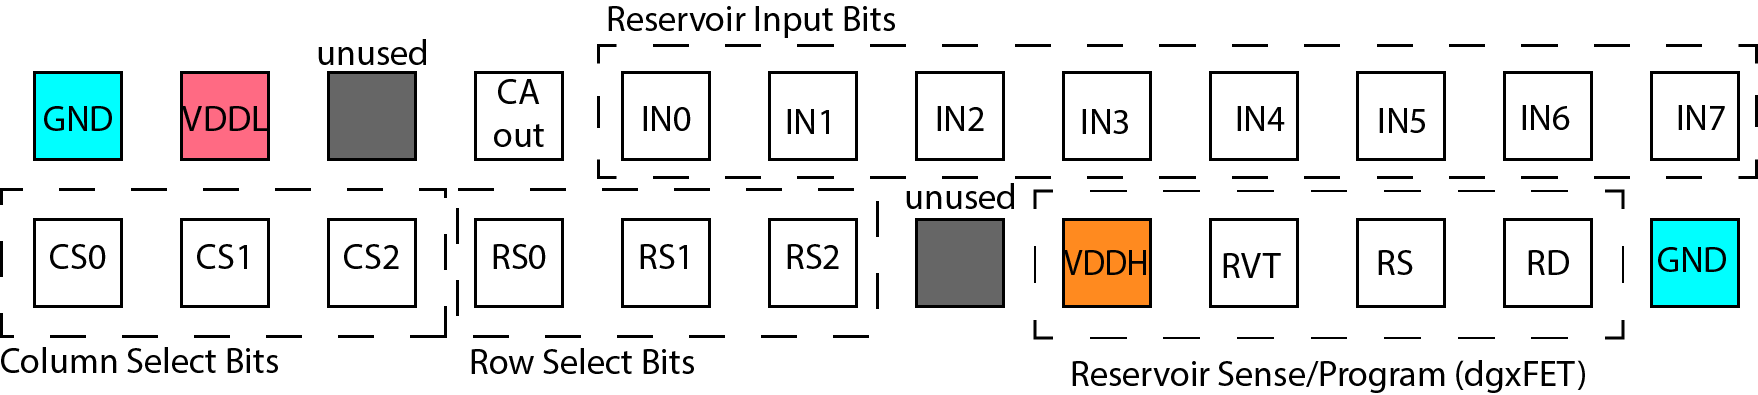

In [1]:
f = readlines(open("SpotMeas_20190206_16-27-08_CMORCA.csv","r"))

77-element Array{String,1}:
 "TestParameter ,Measurement.Type ,reservoirComputing"             
 "TestParameter ,MainFrame"                                        
 "TestParameter ,Channel.Type ,SMU ,SMU ,SMU ,SMU"                 
 "TestParameter ,Channel.Unit ,SMU1:MP ,SMU2:MP ,SMU3:MP ,SMU4:MP" 
 "TestParameter ,Channel.IName ,I1 ,I2 ,I3 ,I4"                    
 "TestParameter ,Channel.VName ,V1 ,V2 ,V3 ,V4"                    
 "TestParameter ,Channel.Mode ,V ,V ,V ,V"                         
 "TestParameter ,Channel.Func ,VAR1 ,VAR1 ,VAR1 ,VAR1"             
 "TestParameter ,Channel.Index , , , ,"                            
 "TestParameter ,Channel.Time , , , ,"                             
 "TestParameter ,Measurement.Port.SeriesResistance ,ON ,ON ,ON ,ON"
 "TestParameter ,Measurement.Port.Filter ,0 ,0 ,0 ,0"              
 "TestParameter ,Measurement.Adc.HighSpeed.Mode ,AUTO"             
 ⋮                                                                 
 "DataValue ,  -0.00

In [46]:
f2 = readlines(open("SpotMeas_20190207_16-17-25_ReservoirComp_1.csv","r"))

77-element Array{String,1}:
 "TestParameter ,Measurement.Type ,reservoirComputing"             
 "TestParameter ,MainFrame"                                        
 "TestParameter ,Channel.Type ,SMU ,SMU ,SMU ,SMU"                 
 "TestParameter ,Channel.Unit ,SMU1:MP ,SMU2:MP ,SMU3:MP ,SMU4:MP" 
 "TestParameter ,Channel.IName ,I1 ,I2 ,I3 ,I4"                    
 "TestParameter ,Channel.VName ,V1 ,V2 ,V3 ,V4"                    
 "TestParameter ,Channel.Mode ,V ,V ,V ,V"                         
 "TestParameter ,Channel.Func ,VAR1 ,VAR1 ,VAR1 ,VAR1"             
 "TestParameter ,Channel.Index , , , ,"                            
 "TestParameter ,Channel.Time , , , ,"                             
 "TestParameter ,Measurement.Port.SeriesResistance ,ON ,ON ,ON ,ON"
 "TestParameter ,Measurement.Port.Filter ,0 ,0 ,0 ,0"              
 "TestParameter ,Measurement.Adc.HighSpeed.Mode ,AUTO"             
 ⋮                                                                 
 "DataValue ,  -0.00

In [2]:
reg = r"^DataValue ,\s+(\S+)\s+,\s+(\S+)\s+,\s+(\S+)\s+,\s+(\S+)"

r"^DataValue ,\s+(\S+)\s+,\s+(\S+)\s+,\s+(\S+)\s+,\s+(\S+)"

In [3]:
voltages = []
for line in f
    m = match(reg, line)
    if m != nothing
        vout = Meta.parse(m[4])
        append!(voltages, vout)
    end
end


In [51]:
function readvoltages(file::String)
    voltages = []
    f = readlines(open(file,"r"))
    
    for line in f
        m = match(reg, line)
        if m != nothing
            vout = Meta.parse(m[4])
            append!(voltages, vout)
        end
    end
    
    return voltages
end

readvoltages (generic function with 1 method)

In [52]:
v3 = readvoltages("SpotMeas_20190207_16-17-25_ReservoirComp_2.csv")

56-element Array{Any,1}:
 1.1562
 1.1536
 0.0255
 0.0278
 0.0274
 0.0262
 0.0257
 0.026 
 1.1566
 0.0256
 1.1506
 0.0275
 0.0277
 ⋮     
 1.149 
 0.027 
 1.1503
 0.0263
 1.1525
 1.1512
 1.1495
 1.1465
 1.1486
 1.1502
 1.1492
 1.1475

In [5]:
using PyPlot

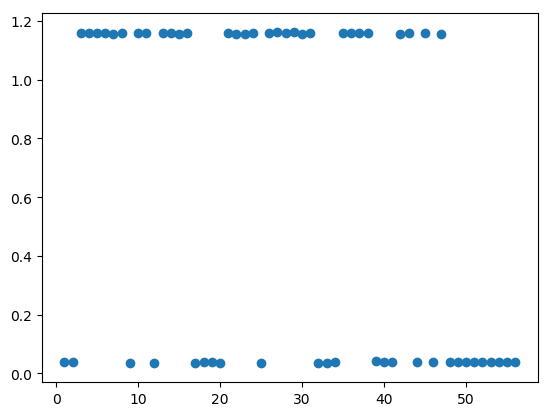

PyObject <matplotlib.collections.PathCollection object at 0x7f548dc172b0>

In [9]:
scatter(collect(1:56), voltages)

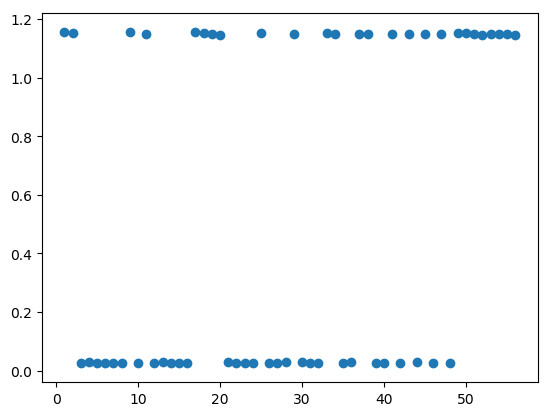

PyObject <matplotlib.collections.PathCollection object at 0x7f5487637080>

In [53]:
scatter(collect(1:56), v3)

In [73]:
function plot_results(x::String)
    imshow(rotr90(cat([1.15,0,0,0, 0,0,0,0],reshape(readvoltages(x),8,7), dims=2)),cmap="bone")
    xlabel("CA Column")
    ylabel("CA Row")
    colorbar()
end

plot_results (generic function with 2 methods)

In [184]:

function plot_results2(x::String, rule::Int)
    voltages = reshape(readvoltages(x),8,7)
    vhigh = maximum(voltages)
    
    fig = figure(figsize=(11,5))
    fig[:suptitle](string("Rule ", rule))
    
    ax = subplot(121)
    ax[:set_title]("Software CA")
    im = ax[:imshow](convert(Array{Int,2},rotr90(CA(rule, [1,0,0,0, 0,0,0,0], 7))),cmap="bone")
    ax[:set_xlabel]("Column")
    ax[:set_xticks](collect(0:7), string.(collect(0:7)))
    ax[:set_ylabel]("Row")
    cbar = fig[:colorbar](im)
    cbar[:ax][:set_ylabel]("State")
    
    ax = subplot(122)
    ax[:set_title]("Hardware CA")
    im = ax[:imshow](rotr90(cat([vhigh,0,0,0, 0,0,0,0], voltages, dims=2)), cmap="bone")
    ax[:set_xlabel]("Column")
    ax[:set_xticks](collect(0:7), string.(collect(0:7)))
    ax[:set_ylabel]("Row")
    cbar = fig[:colorbar](im)
    cbar[:ax][:set_ylabel]("Voltage")
end


plot_results2 (generic function with 1 method)

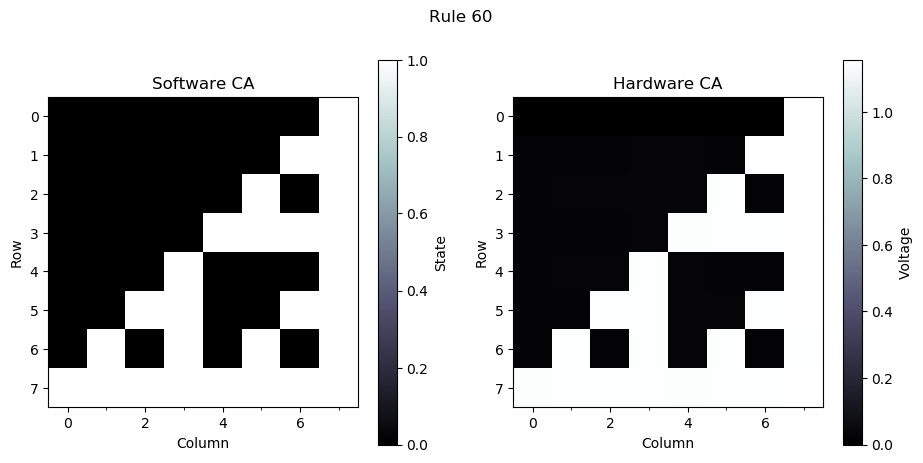

PyObject Text(899.056,0.5,'Voltage')

In [185]:
plot_results2("SpotMeas_20190207_16-17-25_ReservoirComp_2.csv", 60)

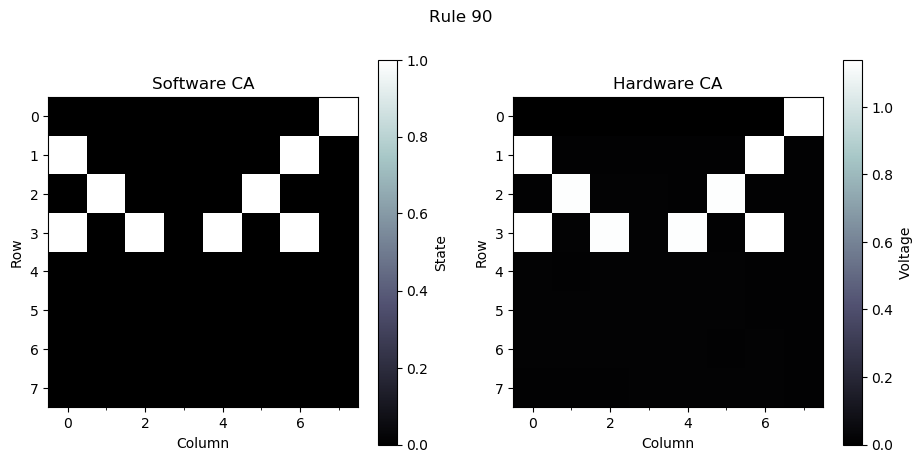

PyObject Text(899.056,0.5,'Voltage')

In [186]:
plot_results2("SpotMeas_20190207_16-17-25_ReservoirComp_3.csv", 90)

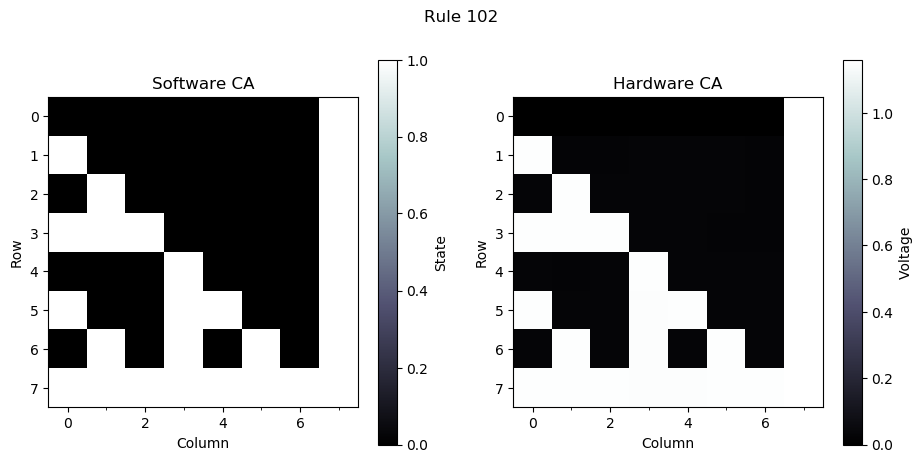

PyObject Text(899.056,0.5,'Voltage')

In [187]:
plot_results2("SpotMeas_20190207_16-17-25_ReservoirComp_4.csv", 102)

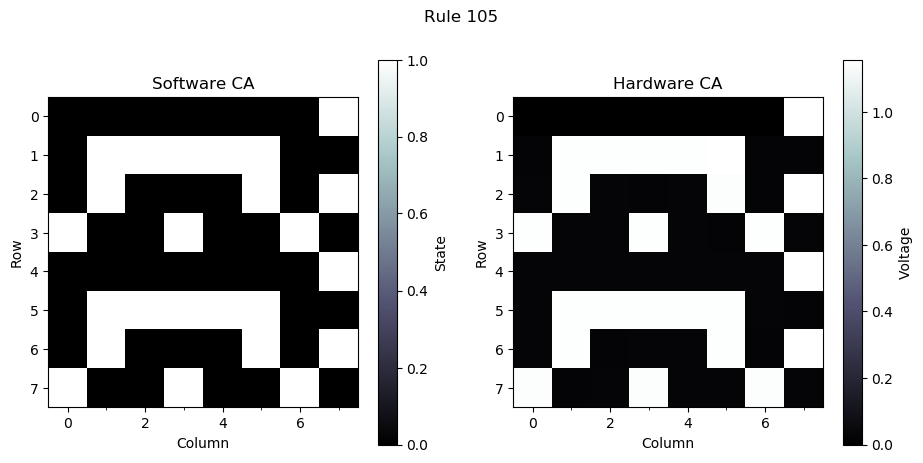

PyObject Text(899.056,0.5,'Voltage')

In [188]:
plot_results2("SpotMeas_20190208_14-43-27_CMOR5.csv", 105)

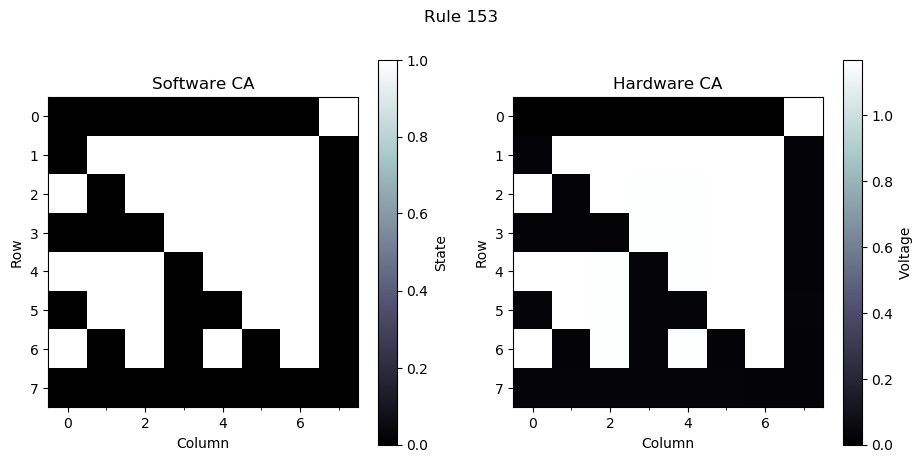

PyObject Text(899.056,0.5,'Voltage')

In [189]:
plot_results2("SpotMeas_20190208_14-43-27_CMOR6.csv", 153)

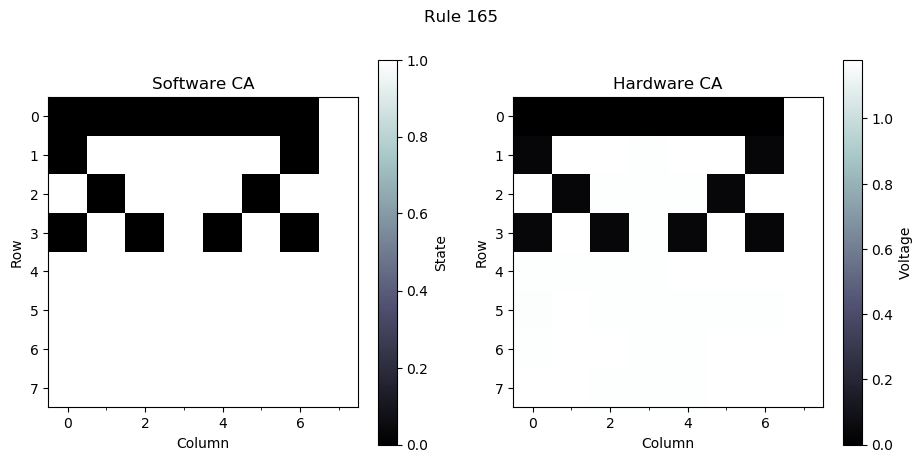

PyObject Text(899.056,0.5,'Voltage')

In [190]:
plot_results2("SpotMeas_20190208_14-43-27_CMOR7.csv", 165)

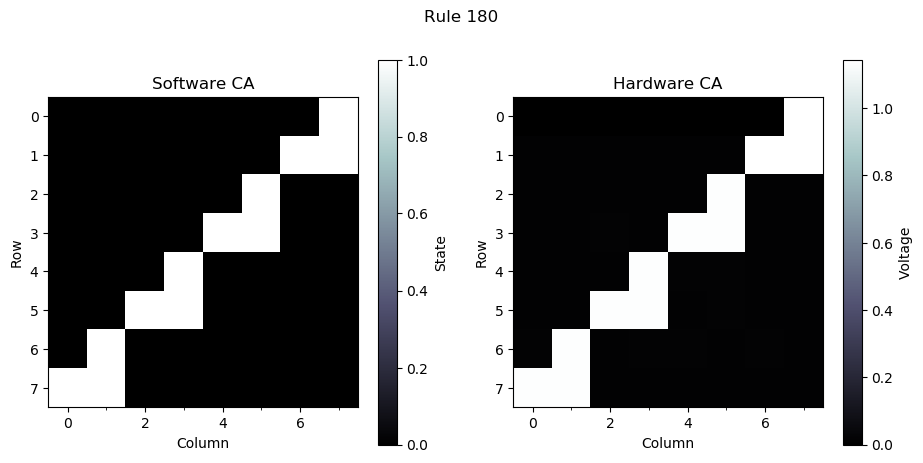

PyObject Text(899.056,0.5,'Voltage')

In [191]:
plot_results2("SpotMeas_20190208_14-43-27_CMOR8.csv", 180)

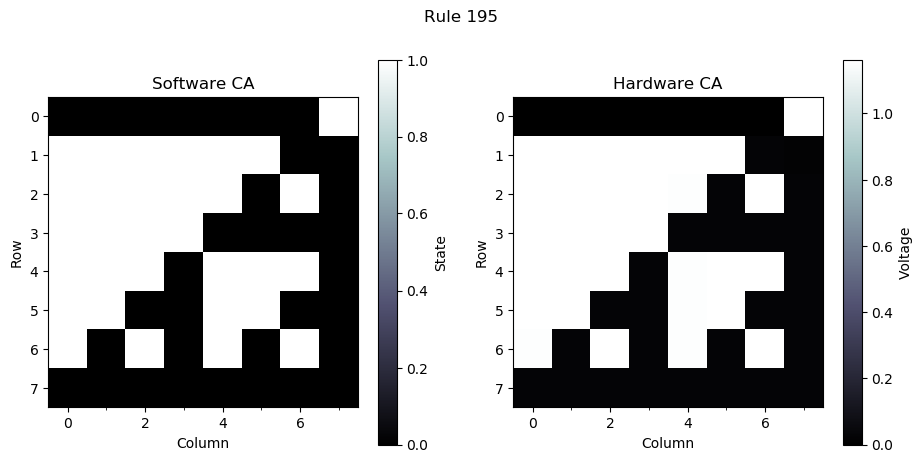

PyObject Text(899.056,0.5,'Voltage')

In [192]:
plot_results2("SpotMeas_20190208_14-43-27_CMOR9_3.csv", 195)

Rule 60

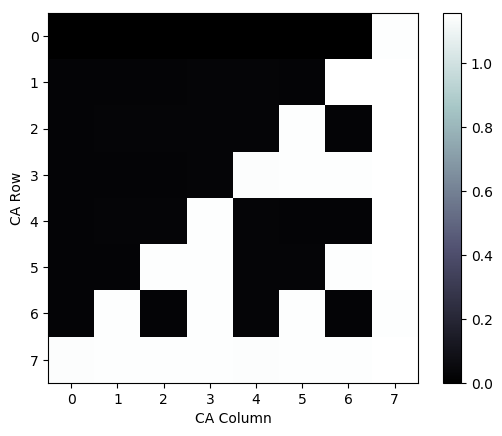

PyObject <matplotlib.colorbar.Colorbar object at 0x7f54870666d8>

In [74]:
plot_results("SpotMeas_20190207_16-17-25_ReservoirComp_2.csv")

Rule 90

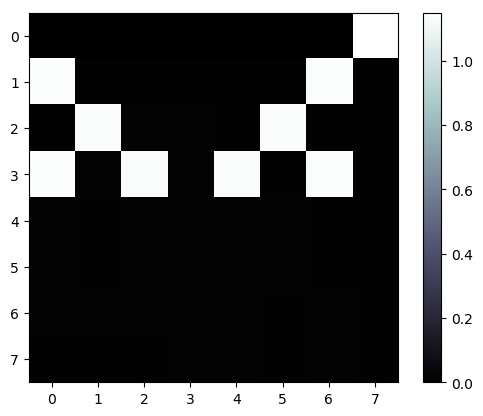

PyObject <matplotlib.colorbar.Colorbar object at 0x7f54871fac50>

In [71]:
plot_results("SpotMeas_20190207_16-17-25_ReservoirComp_3.csv")

Rule 102

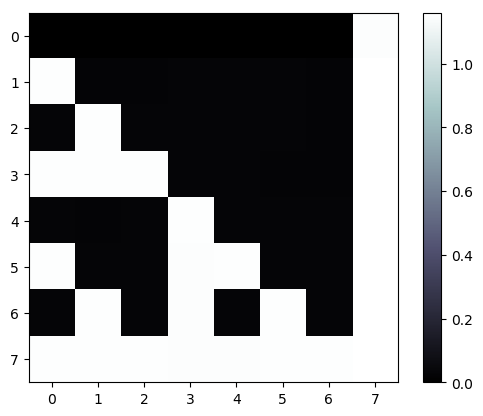

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5487135198>

In [72]:
plot_results("SpotMeas_20190207_16-17-25_ReservoirComp_4.csv")

Rule 105

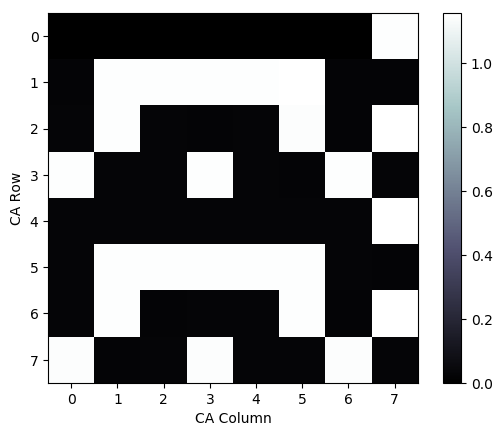

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5486f92c18>

In [75]:
plot_results("SpotMeas_20190208_14-43-27_CMOR5.csv")

Rule 153

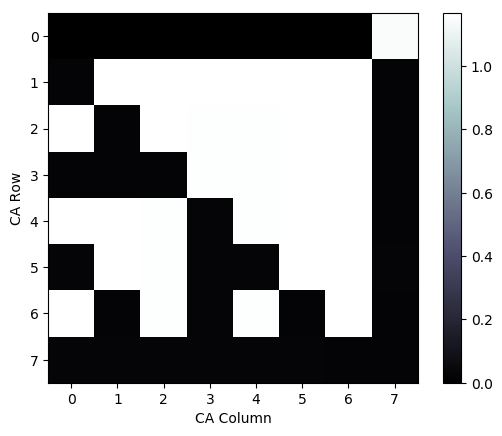

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5486ecf198>

In [76]:
plot_results("SpotMeas_20190208_14-43-27_CMOR6.csv")

Rule 165

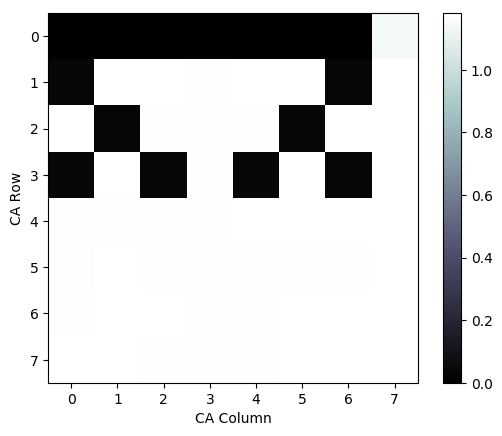

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5486e036d8>

In [77]:
plot_results("SpotMeas_20190208_14-43-27_CMOR7.csv")

Rule 180

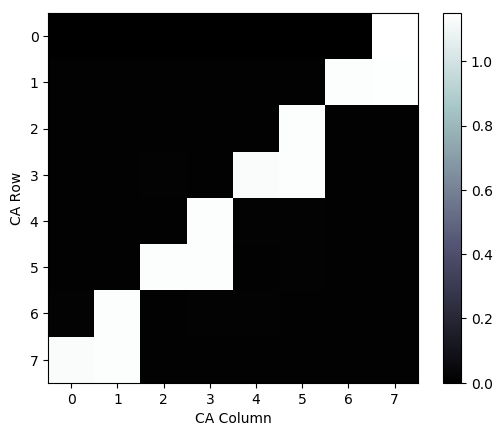

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5486dfa518>

In [78]:
plot_results("SpotMeas_20190208_14-43-27_CMOR8.csv")

Rule 195

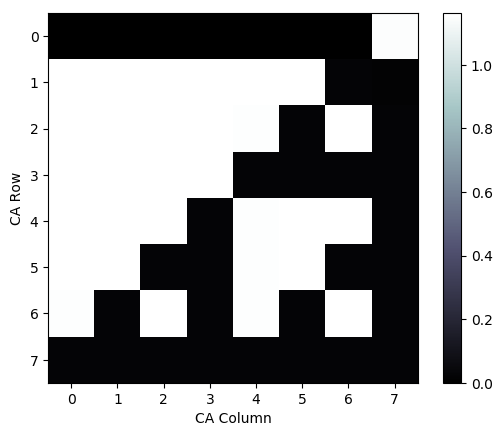

PyObject <matplotlib.colorbar.Colorbar object at 0x7f547caa70b8>

In [81]:
plot_results("SpotMeas_20190208_14-43-27_CMOR9_3.csv")

In [27]:
permutation = []

for i in 0:7
    b = reverse(digits(i, pad=3, base=2))
    d = 0
    for i in 0:2
        d += (2^i)*b[i+1]
    end
    append!(permutation, d)
    print(d)
end
    

04261537

In [30]:
permutation .+= 1

8-element Array{Any,1}:
 1
 5
 3
 7
 2
 6
 4
 8

In [32]:
volt2d = reshape(voltages,7,8) .> 0.5

7×8 BitArray{2}:
 false   true   true   true   true   true   true  false
 false  false   true   true   true   true  false  false
  true   true  false   true   true   true   true  false
  true   true  false  false  false  false  false  false
  true  false  false   true  false  false   true  false
  true   true  false   true  false  false  false  false
  true   true   true   true   true   true  false  false

In [35]:
volt2d[1, permutation]

8-element BitArray{1}:
 false
  true
  true
  true
  true
  true
  true
 false

In [44]:
remapped = falses(7,8)
for (i,r) in enumerate(permutation[1:7])
    remapped[i,:] = volt2d[r, permutation]
end
    

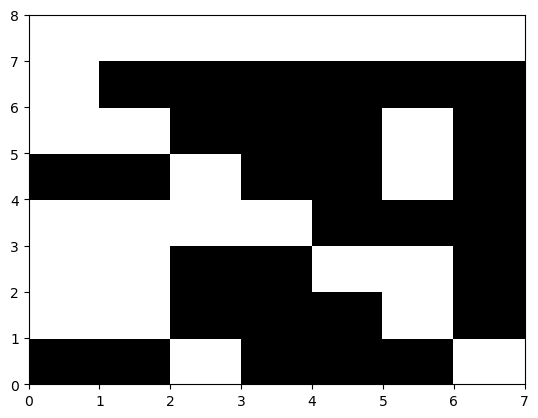

PyObject <matplotlib.collections.QuadMesh object at 0x7f5487717240>

In [45]:
pcolormesh(rotr90(remapped), cmap="binary")

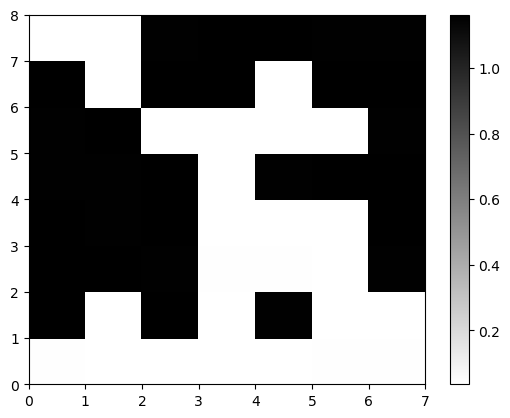

PyObject <matplotlib.colorbar.Colorbar object at 0x7f54879229e8>

In [28]:
pcolormesh(rotl90(reshape(voltages,7,8)), cmap="binary")
colorbar()

In [18]:
rsvs = reshape(voltages,7,8) .> 0.5

7×8 BitArray{2}:
 false   true   true   true   true   true   true  false
 false  false   true   true   true   true  false  false
  true   true  false   true   true   true   true  false
  true   true  false  false  false  false  false  false
  true  false  false   true  false  false   true  false
  true   true  false   true  false  false  false  false
  true   true   true   true   true   true  false  false

In [21]:
sum(rsvs,dims=2)

7×1 Array{Int64,2}:
 6
 4
 6
 2
 3
 3
 6

In [14]:
sum(voltages .> 0.5)

30